# Importing the Libraries

In [67]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing, model_selection
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from keras.models import Sequential
from keras.layers import GRU, LSTM, Bidirectional, Conv1D, Dense, Activation, Dropout, BatchNormalization, ReLU 
from keras import regularizers, optimizers
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Loading and Preprocessing the Data

In [2]:
df=pd.read_csv('EEG_data.csv')
data = pd.read_csv('demographic_info.csv')

In [3]:
data = data.rename(columns = {'subject ID': 'SubjectID'})
df = df.merge(data,how = 'inner',on = 'SubjectID')
df.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln,age,ethnicity,gender
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0,25,Han Chinese,M
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0,25,Han Chinese,M
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0,25,Han Chinese,M
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0,25,Han Chinese,M
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0,25,Han Chinese,M


In [4]:
Data = df.copy()

In [5]:
Data.pop('SubjectID')
Data.pop('VideoID')
Data.pop('predefinedlabel')
Data.pop('user-definedlabeln')
Data.pop(' age')
Data.pop(' ethnicity')
Data.pop(' gender')
Data

,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2
0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0
1,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0
2,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0
3,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0
4,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0
...,...,...,...,...,...,...,...,...,...,...,...
12806,64.0,38.0,-39.0,127574.0,9951.0,709.0,21732.0,3872.0,39728.0,2598.0,960.0
12807,61.0,35.0,-275.0,323061.0,797464.0,153171.0,145805.0,39829.0,571280.0,36574.0,10010.0
12808,60.0,29.0,-426.0,680989.0,154296.0,40068.0,39122.0,10966.0,26975.0,20427.0,2024.0
12809,60.0,29.0,-84.0,366269.0,27346.0,11444.0,9932.0,1939.0,3283.0,12323.0,1764.0


In [6]:
Data["Attention"] = Data["Attention"] / Data["Attention"].abs().max()
Data["Mediation"] = Data["Mediation"] / Data["Mediation"].abs().max()
Data["Raw"] = Data["Raw"] / Data["Raw"].abs().max()

In [7]:
x = np.array(Data)
y = np.array(df['user-definedlabeln'])

In [8]:
x_train = x[:10000, :]
y_train = y[:10000]
x_val = x[10000:11405, :]
y_val = y[10000:11405]
x_test = x[11405:, :]
y_test = y[11405:]

In [9]:
train = timeseries_dataset_from_array(x_train, sequence_length=1, batch_size=64, targets=y_train)
test = timeseries_dataset_from_array(x_test, sequence_length=1, targets=y_test)
val = timeseries_dataset_from_array(x_val, sequence_length=1, targets=y_val)

# Implementing the Network and Training

In [51]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", kernel_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", kernel_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=regularizers.l2(1e-5))))
model.add(Dropout(0.2))
model.add(Bidirectional(GRU(32, return_sequences=True, kernel_regularizer=regularizers.l2(1e-5))))
model.add(Dropout(0.3))
model.add(Bidirectional(GRU(32, kernel_regularizer=regularizers.l2(1e-5))))
model.add(Dropout(0.3))
model.add(Dense(32, kernel_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dense(1, activation="sigmoid"))

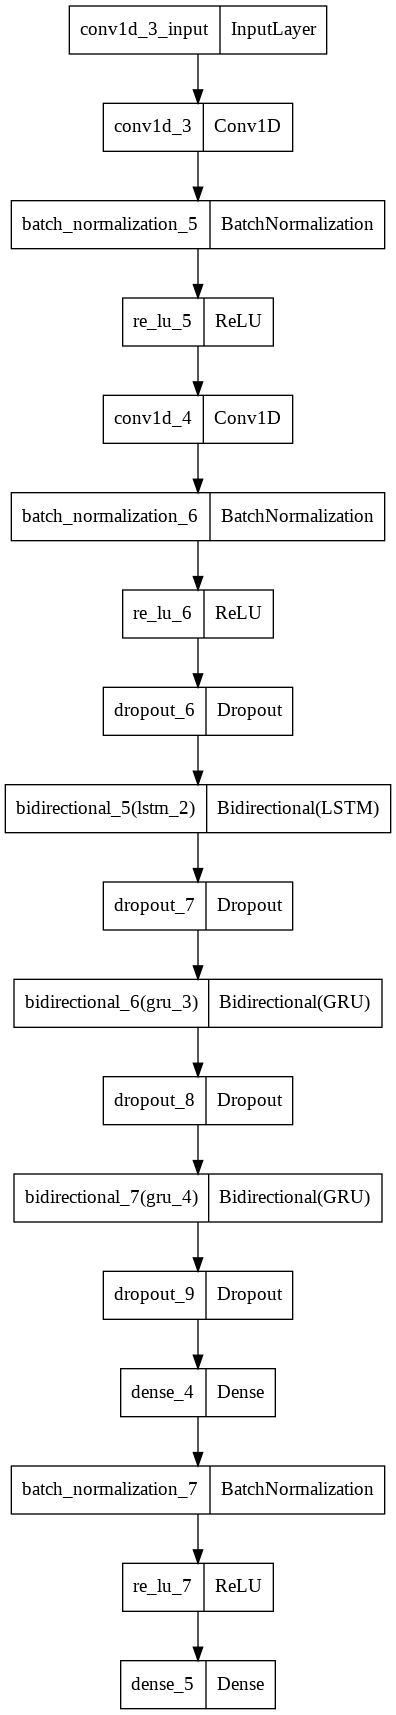

In [37]:
tf.keras.utils.plot_model(model)

In [46]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 4))

In [49]:
model.compile(optimizer=SGD(learning_rate=1e-8, momentum=0.9), loss=['binary_crossentropy'], metrics=['accuracy'])

First we will find the optimal Learning Rate

In [27]:
history = model.fit(train, epochs=25, callbacks=[lr_schedule])

Epoch 1/25
157/157 [==============================] - 13s 18ms/step - loss: 0.7683 - accuracy: 0.4858 - lr: 1.0000e-08
Epoch 2/25
157/157 [==============================] - 3s 18ms/step - loss: 0.7685 - accuracy: 0.4771 - lr: 1.7783e-08
Epoch 3/25
157/157 [==============================] - 3s 18ms/step - loss: 0.7684 - accuracy: 0.4810 - lr: 3.1623e-08
Epoch 4/25
157/157 [==============================] - 3s 18ms/step - loss: 0.7681 - accuracy: 0.4790 - lr: 5.6234e-08
Epoch 5/25
157/157 [==============================] - 3s 18ms/step - loss: 0.7709 - accuracy: 0.4760 - lr: 1.0000e-07
Epoch 6/25
157/157 [==============================] - 3s 18ms/step - loss: 0.7680 - accuracy: 0.4858 - lr: 1.7783e-07
Epoch 7/25
157/157 [==============================] - 3s 18ms/step - loss: 0.7684 - accuracy: 0.4776 - lr: 3.1623e-07
Epoch 8/25
157/157 [==============================] - 3s 19ms/step - loss: 0.7688 - accuracy: 0.4825 - lr: 5.6234e-07
Epoch 9/25
157/157 [==============================] - 3

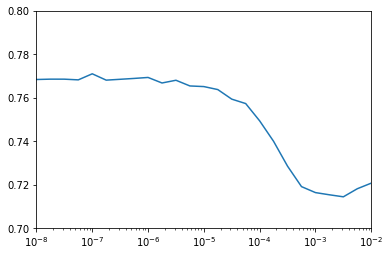

In [29]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 0.01, 0.7, 0.8])
plt.show()

In [52]:
model.compile(optimizer=SGD(learning_rate=1e-3, momentum=0.9), loss=['binary_crossentropy'], metrics=['accuracy'])

In [53]:
history = model.fit(train, epochs=300, validation_data=val)

Epoch 1/300
157/157 [==============================] - 62s 31ms/step - loss: 0.7182 - accuracy: 0.5036 - val_loss: 0.7009 - val_accuracy: 0.2783
Epoch 2/300
157/157 [==============================] - 3s 19ms/step - loss: 0.7120 - accuracy: 0.5126 - val_loss: 0.7025 - val_accuracy: 0.3409
Epoch 3/300
157/157 [==============================] - 3s 19ms/step - loss: 0.7100 - accuracy: 0.5077 - val_loss: 0.7045 - val_accuracy: 0.3794
Epoch 4/300
157/157 [==============================] - 3s 20ms/step - loss: 0.7085 - accuracy: 0.5134 - val_loss: 0.7217 - val_accuracy: 0.2826
Epoch 5/300
157/157 [==============================] - 3s 19ms/step - loss: 0.7052 - accuracy: 0.5162 - val_loss: 0.7063 - val_accuracy: 0.5082
Epoch 6/300
157/157 [==============================] - 3s 19ms/step - loss: 0.7039 - accuracy: 0.5207 - val_loss: 0.7128 - val_accuracy: 0.2996
Epoch 7/300
157/157 [==============================] - 3s 19ms/step - loss: 0.7017 - accuracy: 0.5144 - val_loss: 0.7250 - val_accuracy

We will train more

In [55]:
model.compile(optimizer=SGD(learning_rate=1e-5, momentum=0.9), loss=['binary_crossentropy'], metrics=['accuracy'])
history2 = model.fit(train, epochs=100, validation_data=val)

Epoch 1/100
157/157 [==============================] - 13s 31ms/step - loss: 0.6136 - accuracy: 0.6750 - val_loss: 0.6893 - val_accuracy: 0.5737
Epoch 2/100
157/157 [==============================] - 3s 19ms/step - loss: 0.6093 - accuracy: 0.6751 - val_loss: 0.7086 - val_accuracy: 0.5260
Epoch 3/100
157/157 [==============================] - 3s 19ms/step - loss: 0.6070 - accuracy: 0.6812 - val_loss: 0.7073 - val_accuracy: 0.5246
Epoch 4/100
157/157 [==============================] - 3s 20ms/step - loss: 0.6060 - accuracy: 0.6786 - val_loss: 0.7002 - val_accuracy: 0.5502
Epoch 5/100
157/157 [==============================] - 3s 19ms/step - loss: 0.6059 - accuracy: 0.6766 - val_loss: 0.7039 - val_accuracy: 0.5381
Epoch 6/100
157/157 [==============================] - 3s 20ms/step - loss: 0.6064 - accuracy: 0.6809 - val_loss: 0.6985 - val_accuracy: 0.5516
Epoch 7/100
157/157 [==============================] - 3s 20ms/step - loss: 0.6022 - accuracy: 0.6824 - val_loss: 0.6979 - val_accuracy

In [59]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-11 * 10**(epoch / 4))
model.compile(optimizer=SGD(learning_rate=1e-11, momentum=0.9), loss=['binary_crossentropy'], metrics=['accuracy'])
history3 = model.fit(train, epochs=25, callbacks=[lr_schedule])

Epoch 1/25
157/157 [==============================] - 52s 18ms/step - loss: 0.5916 - accuracy: 0.6915 - lr: 1.0000e-11
Epoch 2/25
157/157 [==============================] - 3s 18ms/step - loss: 0.5903 - accuracy: 0.6950 - lr: 1.7783e-11
Epoch 3/25
157/157 [==============================] - 3s 18ms/step - loss: 0.5925 - accuracy: 0.6925 - lr: 3.1623e-11
Epoch 4/25
157/157 [==============================] - 3s 18ms/step - loss: 0.5924 - accuracy: 0.6921 - lr: 5.6234e-11
Epoch 5/25
157/157 [==============================] - 5s 34ms/step - loss: 0.5938 - accuracy: 0.6921 - lr: 1.0000e-10
Epoch 6/25
157/157 [==============================] - 3s 21ms/step - loss: 0.5922 - accuracy: 0.6936 - lr: 1.7783e-10
Epoch 7/25
157/157 [==============================] - 3s 18ms/step - loss: 0.5918 - accuracy: 0.6936 - lr: 3.1623e-10
Epoch 8/25
157/157 [==============================] - 3s 18ms/step - loss: 0.5975 - accuracy: 0.6917 - lr: 5.6234e-10
Epoch 9/25
157/157 [==============================] - 3

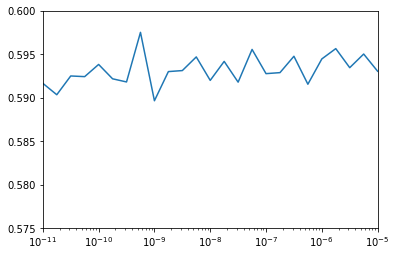

In [64]:
plt.semilogx(history3.history["lr"], history3.history["loss"])
plt.axis([1e-11, 1e-5, 0.575, 0.6])
plt.show()

In [65]:
model.compile(optimizer=SGD(learning_rate=1e-9, momentum=0.9), loss=['binary_crossentropy'], metrics=['accuracy'])
history3 = model.fit(train, epochs=100, validation_data=val)

Epoch 1/100
157/157 [==============================] - 21s 85ms/step - loss: 0.5945 - accuracy: 0.6914 - val_loss: 0.6969 - val_accuracy: 0.5708
Epoch 2/100
157/157 [==============================] - 3s 20ms/step - loss: 0.5949 - accuracy: 0.6877 - val_loss: 0.6989 - val_accuracy: 0.5601
Epoch 3/100
157/157 [==============================] - 3s 20ms/step - loss: 0.5916 - accuracy: 0.6962 - val_loss: 0.6986 - val_accuracy: 0.5623
Epoch 4/100
157/157 [==============================] - 3s 20ms/step - loss: 0.5939 - accuracy: 0.6869 - val_loss: 0.6938 - val_accuracy: 0.5815
Epoch 5/100
157/157 [==============================] - 4s 23ms/step - loss: 0.5933 - accuracy: 0.6908 - val_loss: 0.6969 - val_accuracy: 0.5680
Epoch 6/100
157/157 [==============================] - 3s 20ms/step - loss: 0.5929 - accuracy: 0.6919 - val_loss: 0.6989 - val_accuracy: 0.5594
Epoch 7/100
157/157 [==============================] - 3s 20ms/step - loss: 0.5974 - accuracy: 0.6824 - val_loss: 0.6957 - val_accuracy

# Evaluation

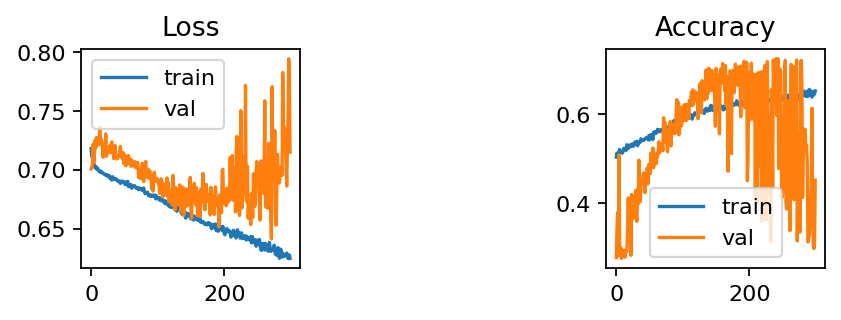

In [54]:
plt.figure( dpi=160)

plt.subplot(231)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

plt.subplot(233)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

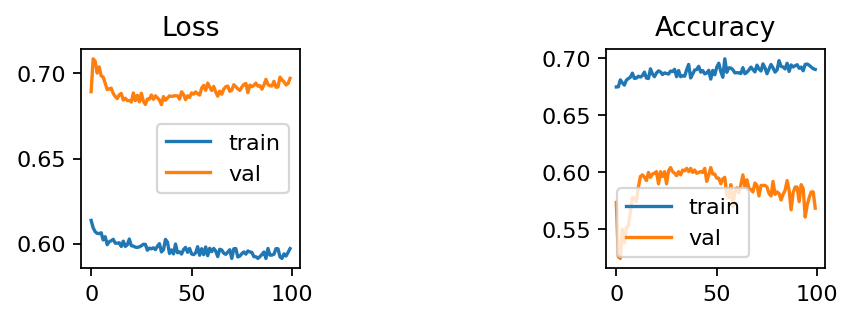

In [56]:
plt.figure( dpi=160)

plt.subplot(231)
plt.title('Loss')
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='val')
plt.legend()

plt.subplot(233)
plt.title('Accuracy')
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='val')
plt.legend()
plt.show()

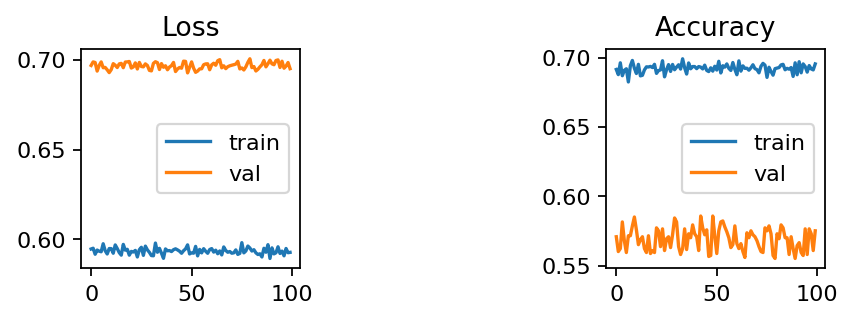

In [66]:
plt.figure( dpi=160)

plt.subplot(231)
plt.title('Loss')
plt.plot(history3.history['loss'], label='train')
plt.plot(history3.history['val_loss'], label='val')
plt.legend()

plt.subplot(233)
plt.title('Accuracy')
plt.plot(history3.history['accuracy'], label='train')
plt.plot(history3.history['val_accuracy'], label='val')
plt.legend()
plt.show()

In [69]:
y_hat = model.predict(test)

11/11 [==============================] - 3s 21ms/step


In [70]:
y_hat[y_hat>=0.5] = 1
y_hat[y_hat<0.5] = 0


For Test Set
F1 score:  0.5007112375533428
Accuracy:  0.5007112375533428
Precision:  0.5007112375533428
Recall:  0.5007112375533428
Confusion Matrix: 



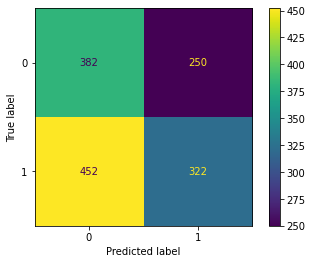

In [71]:
print('\nFor Test Set')
f1 = f1_score(y_test, y_hat, average='micro')
print('F1 score: ' , f1)

accuracy = accuracy_score(y_test, y_hat)
print('Accuracy: ' , accuracy)

precision = precision_score(y_test, y_hat, average='micro')
print('Precision: ' , precision)

recall = recall_score(y_test, y_hat, average='micro')
print('Recall: ' , recall)

matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, y_hat))
print('Confusion Matrix: \n')
matrix.plot()
plt.show()